First I need to import Keras - a library for deep learning. It's a high level API built on top of TensorFlow which is another library for buidling machine learning models. Keras is very easy to use and great for a quick introduction into various deep learning models. There is more information available at https://keras.io/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

/home/kostya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Pulling Apple stock prices as well as Nasdaq Composite index vlues. Nasdaq can provide some additional information on general trends in the technology sector. I decided to add Boeing stock prices as for some reason it was correlated to Apple.

In [2]:
apple = quandl.get("EOD/AAPL", start_date='2013-01-01', end_date='2016-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')
nasdaq = quandl.get('NASDAQOMX/COMP', start_date='2013-01-01', end_date='2016-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')
ba = quandl.get('EOD/BA', start_date='2013-01-01', end_date='2016-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')

Preprocessing train data. Original data inputs have different ranges which introduces bias into the model. It's important to standardize all model inputs so they are comparable.

I am going to look at 40 previous trading days to predict Apple close price of the next day. Input data vector will also have 40 previous close prices for Boeing and 40 previous Nasdaq Index values.

The model will be trained on 4 years of data: 2013 through 2016.

In [3]:
train = apple[['Adj_Close']].copy()
train.rename(columns={'Adj_Close':'aapl'}, inplace=True)
train = train.join(nasdaq[['Index Value']])
train = train.join(ba[['Adj_Close']])
train.rename(columns={'Index Value':'nasdaq', 'Adj_Close':'ba'}, inplace=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_sc = scaler.fit_transform(train)

X_train = []
y_train = []
for i in range(40, len(train)):
    X_train.append(
            [train_sc[i-40:i, 0],
             train_sc[i-40:i, 1],
             train_sc[i-40:i, 2]
             ])
    y_train.append(train_sc[i, 0])
X_train = np.array(X_train)

X_train = X_train.transpose(0,2,1)
y_train = np.array(y_train)

Neural network consists of multiple layers of neurons. I am going to create one with 4 "hidden" layers plus input and output layers. Input layer will have 120 values: 40 AAPL stock prices, 40 BA stock prices and 40 Nasdaq index prices. Each "hidden" layer will have either 60 or 120 neurons - assigned in the next step. Output layer will have only one neuron cause i am trying to predict just one daily price of AAPL stock.

Keras library allows to use different types of layers for neural networks. Probably the best type of layer for RNN - recurrent neural network is LSTM layer or long short-term memory. Here is more information about it: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Dropout is used to randomly disable a certain fraction of neurons in the layer during model training to prevent overfitting. I will be dropping 20% of neurons in each layer in this case.

In [4]:
def regressor_fn(opt, unt):
    regressor = Sequential()
    #First layer
    regressor.add(LSTM(units = unt, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(0.2))
    
    #Second layer
    regressor.add(LSTM(units = unt, return_sequences = True))
    regressor.add(Dropout(0.2))
    
    #Third layer
    regressor.add(LSTM(units = unt, return_sequences = True))
    regressor.add(Dropout(0.2))
    
    #Fourth layer
    regressor.add(LSTM(units = unt))
    regressor.add(Dropout(0.2))
    
    #Output layer
    regressor.add(Dense(units = 1))
    
    regressor.compile(optimizer = opt, loss = 'mean_squared_error')
    return regressor

I am using GridSearchCV class from scikit-learn library to find the best combination of hyper-parameters for my model such as batch size, number of neurons, optimizer, etc and also to perform cross validation of the model.

Optimizer is an algorithm which helps to minimize loss function while training the model (adjusting weights and biases). Adam optimizer is widely used as it converges fast and often outperforms other optimezers. I decided to try rmsprop optimizer as it is suggested for RNN models according to https://keras.io/

Cross validation is important cause it allows to test model performance on multiple data samples before running it against final test data. It helps to make sure the model is showing comparable accuracy in and out of sample. I am using 4-fold cross validation for this model.

KerasRegressor is a wrapper from Keras library that allows to use scikit-learn GridSearchCV in Keras model.

In [5]:
regressor = KerasRegressor(build_fn = regressor_fn)
tuned_params = {'batch_size': [16, 32],
                'epochs': [100],
                'unt': [60, 120],
                'opt': ['adam', 'rmsprop']}
grid = GridSearchCV(estimator = regressor,
                    param_grid = tuned_params,
                    scoring = 'neg_mean_squared_error',
                    n_jobs = -1,
                    cv = 4)

Fitting the model

In [6]:
import time
start_time = time.time()
grid = grid.fit(X_train, y_train)
end_time = time.time() - start_time

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
726/726 [==============================] - 54s 74ms/step - loss: 0.1799
Epoch 2/100
726/726 [==============================] - 54s 75ms/step - loss: 0.2295
Epoch 2/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0458
Epoch 3/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0572
Epoch 3/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0450
Epoch 3/100
726/726 [==============================] - 38s 53ms/step - loss: 0.0478
Epoch 3/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0505
Epoch 4/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0387
Epoch 4/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0422
Epoch 4/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0409
Epoch 4/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0441
Epoch 5/100
Epoch 5/100
726/726 [=======

726/726 [==============================] - 37s 51ms/step - loss: 0.0193
Epoch 24/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0154
Epoch 25/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0225
Epoch 25/100
726/726 [==============================] - 38s 53ms/step - loss: 0.0208
Epoch 25/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0180
Epoch 26/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0216
Epoch 26/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0233
Epoch 26/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0179
Epoch 26/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0186
Epoch 27/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0229
Epoch 27/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0189
Epoch 27/100
726/726 [==============================] - 38s 53ms/step - loss: 

Epoch 48/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0224
Epoch 48/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0161
Epoch 48/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0151
Epoch 49/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0192
Epoch 49/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0180
Epoch 49/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0133
Epoch 49/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0146
Epoch 50/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0201
Epoch 50/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0153
Epoch 50/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0135
Epoch 51/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0180
Epoch 51/100
726/726 [==============================] - 35s 49ms/

726/726 [==============================] - 37s 51ms/step - loss: 0.0153
Epoch 70/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0113
Epoch 71/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0107
Epoch 71/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0152
Epoch 71/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0151
Epoch 71/100
726/726 [==============================] - 37s 50ms/step - loss: 0.0110
Epoch 72/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0114
Epoch 72/100
726/726 [==============================] - 37s 50ms/step - loss: 0.0158
Epoch 72/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0155
Epoch 72/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0123
Epoch 73/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0114
Epoch 73/100
726/726 [==============================] - 37s 51ms/step - loss: 

726/726 [==============================] - 36s 50ms/step - loss: 0.0109
Epoch 94/100
726/726 [==============================] - 37s 50ms/step - loss: 0.0117
Epoch 94/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0157
Epoch 94/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0155
Epoch 94/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0108
Epoch 95/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0119
Epoch 95/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0162
Epoch 95/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0169
Epoch 95/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0094
Epoch 96/100
726/726 [==============================] - 37s 50ms/step - loss: 0.0101
Epoch 96/100
726/726 [==============================] - 36s 49ms/step - loss: 0.0138
Epoch 96/100
726/726 [==============================] - 37s 52ms/step - loss: 

Epoch 17/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0224
Epoch 18/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0166
Epoch 18/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0155
Epoch 18/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0215
Epoch 18/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0244
Epoch 19/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0154
Epoch 19/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0157
Epoch 19/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0209
Epoch 19/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0213
Epoch 20/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0150
Epoch 20/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0177
Epoch 20/100
726/726 [==============================] - 72s 99ms/

726/726 [==============================] - 72s 99ms/step - loss: 0.0097
Epoch 41/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0142
Epoch 42/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0108
Epoch 42/100
726/726 [==============================] - 71s 97ms/step - loss: 0.0142
Epoch 42/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0106
Epoch 42/100
726/726 [==============================] - 71s 97ms/step - loss: 0.0156
Epoch 43/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0115
Epoch 43/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0137
Epoch 43/100
726/726 [==============================] - 70s 97ms/step - loss: 0.0108
Epoch 43/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0158
Epoch 44/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0119
Epoch 44/100
726/726 [==============================] - 72s 99ms/step - loss: 

726/726 [==============================] - 72s 99ms/step - loss: 0.0102
Epoch 65/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0135
Epoch 66/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0103
Epoch 66/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0126
Epoch 66/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0100
Epoch 66/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0147
Epoch 67/100
726/726 [==============================] - 72s 100ms/step - loss: 0.0107
Epoch 67/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0119
Epoch 67/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0084
Epoch 67/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0113
Epoch 68/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0100
Epoch 68/100
726/726 [==============================] - 71s 98ms/step - loss:

726/726 [==============================] - 70s 97ms/step - loss: 0.0130
Epoch 89/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0093
Epoch 89/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0114
Epoch 90/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0088
Epoch 90/100
726/726 [==============================] - 70s 97ms/step - loss: 0.0088
Epoch 90/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0115
Epoch 90/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0123
Epoch 91/100
726/726 [==============================] - 72s 100ms/step - loss: 0.0096
Epoch 91/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0099
Epoch 91/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0142
Epoch 91/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0114
Epoch 92/100
726/726 [==============================] - 72s 100ms/step - loss

726/726 [==============================] - 37s 50ms/step - loss: 0.0249
Epoch 13/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0269
Epoch 12/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0343
Epoch 12/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0358
Epoch 12/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0253
Epoch 14/100
726/726 [==============================] - 37s 50ms/step - loss: 0.0247
Epoch 13/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0309
Epoch 13/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0320
Epoch 13/100
726/726 [==============================] - 37s 50ms/step - loss: 0.0229
Epoch 15/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0242
Epoch 14/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0328
Epoch 14/100
726/726 [==============================] - 37s 51ms/step - loss: 

726/726 [==============================] - 37s 50ms/step - loss: 0.0166
Epoch 35/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0223
Epoch 35/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0139
Epoch 37/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0244
Epoch 36/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0171
Epoch 36/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0223
Epoch 36/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0155
Epoch 38/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0196
Epoch 37/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0179
Epoch 37/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0219
Epoch 37/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0148
Epoch 39/100
726/726 [==============================] - 36s 49ms/step - loss: 

726/726 [==============================] - 37s 51ms/step - loss: 0.0173
Epoch 58/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0135
Epoch 58/100
726/726 [==============================] - 37s 50ms/step - loss: 0.0170
Epoch 58/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0119
Epoch 60/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0186
Epoch 59/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0149
Epoch 59/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0180
Epoch 59/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0130
Epoch 61/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0169
Epoch 60/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0126
Epoch 60/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0169
Epoch 60/100
726/726 [==============================] - 37s 50ms/step - loss: 

726/726 [==============================] - 38s 53ms/step - loss: 0.0119
Epoch 81/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0146
Epoch 81/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0114
Epoch 83/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0147
Epoch 82/100
726/726 [==============================] - 38s 52ms/step - loss: 0.0115
Epoch 82/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0160
Epoch 82/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0111
Epoch 84/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0151
Epoch 83/100
726/726 [==============================] - 37s 50ms/step - loss: 0.0117
Epoch 83/100
726/726 [==============================] - 36s 50ms/step - loss: 0.0149
Epoch 83/100
726/726 [==============================] - 37s 51ms/step - loss: 0.0116
Epoch 85/100
726/726 [==============================] - 36s 50ms/step - loss: 

Epoch 3/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0839
Epoch 3/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0611
Epoch 4/100
726/726 [==============================] - 72s 100ms/step - loss: 0.0492
Epoch 4/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0679
Epoch 4/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0462
Epoch 5/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0568
Epoch 5/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0431
Epoch 5/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0515
Epoch 5/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0400
Epoch 6/100
726/726 [==============================] - 72s 100ms/step - loss: 0.0503
Epoch 6/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0372
Epoch 6/100
726/726 [==============================] - 71s 98ms/step - los

726/726 [==============================] - 72s 99ms/step - loss: 0.0142
Epoch 27/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0202
Epoch 27/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0148
Epoch 28/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0218
Epoch 28/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0171
Epoch 28/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0199
Epoch 28/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0144
Epoch 29/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0199
Epoch 29/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0142
Epoch 29/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0208
Epoch 29/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0152
Epoch 30/100
726/726 [==============================] - 71s 98ms/step - loss: 

726/726 [==============================] - 72s 99ms/step - loss: 0.0133
Epoch 51/100
726/726 [==============================] - 73s 100ms/step - loss: 0.0176
Epoch 51/100
726/726 [==============================] - 70s 97ms/step - loss: 0.0129
Epoch 52/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0174
Epoch 52/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0122
Epoch 52/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0164
Epoch 52/100
726/726 [==============================] - 72s 100ms/step - loss: 0.0131
Epoch 53/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0156
Epoch 53/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0135
Epoch 53/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0175
Epoch 53/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0125
Epoch 54/100
726/726 [==============================] - 71s 98ms/step - loss

726/726 [==============================] - 71s 98ms/step - loss: 0.0125
Epoch 75/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0107
Epoch 75/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0109
Epoch 76/100
726/726 [==============================] - 73s 100ms/step - loss: 0.0129
Epoch 75/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0135
Epoch 76/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0119
Epoch 76/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0113
Epoch 77/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0156
Epoch 76/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0141
Epoch 77/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0126
Epoch 77/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0114
Epoch 78/100
726/726 [==============================] - 72s 99ms/step - loss:

726/726 [==============================] - 72s 99ms/step - loss: 0.0135
Epoch 98/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0126
Epoch 99/100
726/726 [==============================] - 72s 99ms/step - loss: 0.0100
Epoch 100/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0109
Epoch 99/100
726/726 [==============================] - 72s 100ms/step - loss: 0.0126
Epoch 99/100
726/726 [==============================] - 71s 97ms/step - loss: 0.0129
Epoch 100/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0104
Epoch 100/100
726/726 [==============================] - 71s 98ms/step - loss: 0.0137
Epoch 100/100
726/726 [==============================] - 50s 69ms/step - loss: 0.2120
Epoch 2/100
726/726 [==============================] - 31s 43ms/step - loss: 0.0635
Epoch 3/100
726/726 [==============================] - 30s 41ms/step - loss: 0.0446
Epoch 4/100
726/726 [==============================] - 51s 70ms/step - loss

726/726 [==============================] - 34s 46ms/step - loss: 0.0260
Epoch 21/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0191
Epoch 24/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0305
Epoch 22/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0219
Epoch 22/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0272
Epoch 22/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0193
Epoch 25/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0230
Epoch 23/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0193
Epoch 23/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0218
Epoch 23/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0198
Epoch 26/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0236
Epoch 24/100
726/726 [==============================] - 34s 46ms/step - loss: 

726/726 [==============================] - 33s 46ms/step - loss: 0.0205
Epoch 44/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0192
Epoch 45/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0152
Epoch 45/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0153
Epoch 48/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0195
Epoch 45/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0201
Epoch 46/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0168
Epoch 46/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0161
Epoch 49/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0226
Epoch 46/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0208
Epoch 47/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0155
Epoch 47/100
726/726 [==============================] - 34s 46ms/step - loss: 

726/726 [==============================] - 33s 46ms/step - loss: 0.0122
Epoch 71/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0144
Epoch 68/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0193
Epoch 68/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0191
Epoch 69/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0129
Epoch 72/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0157
Epoch 69/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0186
Epoch 69/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0184
Epoch 70/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0123
Epoch 73/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0151
Epoch 70/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0211
Epoch 70/100
726/726 [==============================] - 34s 47ms/step - loss: 

726/726 [==============================] - 33s 46ms/step - loss: 0.0161
Epoch 91/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0176
Epoch 92/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0118
Epoch 95/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0122
Epoch 92/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0157
Epoch 92/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0168
Epoch 93/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0119
Epoch 96/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0104
Epoch 93/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0159
Epoch 93/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0153
Epoch 94/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0114
Epoch 97/100
726/726 [==============================] - 33s 46ms/step - loss: 

726/726 [==============================] - 39s 54ms/step - loss: 0.0172
Epoch 18/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0245
Epoch 15/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0200
Epoch 15/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0233
Epoch 16/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0183
Epoch 19/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0233
Epoch 16/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0203
Epoch 16/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0221
Epoch 17/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0180
Epoch 20/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0224
Epoch 17/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0173
Epoch 17/100
726/726 [==============================] - 40s 55ms/step - loss: 

726/726 [==============================] - 39s 54ms/step - loss: 0.0139
Epoch 42/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0173
Epoch 40/100
726/726 [==============================] - 40s 56ms/step - loss: 0.0134
Epoch 39/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0162
Epoch 39/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0127
Epoch 43/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0158
Epoch 41/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0120
Epoch 40/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0164
Epoch 40/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0124
Epoch 44/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0166
Epoch 42/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0116
Epoch 41/100
726/726 [==============================] - 39s 54ms/step - loss: 

726/726 [==============================] - 40s 55ms/step - loss: 0.0131
Epoch 62/100
726/726 [==============================] - 40s 54ms/step - loss: 0.0101
Epoch 66/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0140
Epoch 64/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0102
Epoch 63/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0143
Epoch 63/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0095
Epoch 67/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0144
Epoch 65/100
726/726 [==============================] - 40s 54ms/step - loss: 0.0105
Epoch 64/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0145
Epoch 64/100
726/726 [==============================] - 40s 54ms/step - loss: 0.0092
Epoch 68/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0130
Epoch 66/100
726/726 [==============================] - 40s 55ms/step - loss: 

726/726 [==============================] - 40s 55ms/step - loss: 0.0084
Epoch 86/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0114
Epoch 86/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0084
Epoch 90/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0121
Epoch 88/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0105
Epoch 87/100
726/726 [==============================] - 40s 56ms/step - loss: 0.0118
Epoch 87/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0103
Epoch 91/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0136
Epoch 89/100
726/726 [==============================] - 40s 54ms/step - loss: 0.0095
Epoch 88/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0111
Epoch 88/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0100
Epoch 92/100
726/726 [==============================] - 40s 55ms/step - loss: 

726/726 [==============================] - 33s 46ms/step - loss: 0.0287
Epoch 13/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0390
Epoch 9/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0361
Epoch 11/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0437
Epoch 9/100
726/726 [==============================] - 32s 45ms/step - loss: 0.0306
Epoch 14/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0336
Epoch 10/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0412
Epoch 12/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0401
Epoch 10/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0299
Epoch 15/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0287
Epoch 11/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0361
Epoch 13/100
726/726 [==============================] - 33s 46ms/step - loss: 0.

726/726 [==============================] - 33s 45ms/step - loss: 0.0257
Epoch 32/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0188
Epoch 37/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0183
Epoch 33/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0268
Epoch 35/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0238
Epoch 33/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0193
Epoch 38/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0207
Epoch 34/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0253
Epoch 36/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0271
Epoch 34/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0180
Epoch 39/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0197
Epoch 35/100
726/726 [==============================] - 34s 47ms/step - loss: 

726/726 [==============================] - 34s 47ms/step - loss: 0.0227
Epoch 58/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0142
Epoch 61/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0197
Epoch 56/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0166
Epoch 57/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0140
Epoch 62/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0216
Epoch 59/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0201
Epoch 57/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0157
Epoch 58/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0139
Epoch 63/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0185
Epoch 60/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0217
Epoch 58/100
726/726 [==============================] - 33s 45ms/step - loss: 

726/726 [==============================] - 34s 46ms/step - loss: 0.0148
Epoch 80/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0166
Epoch 82/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0130
Epoch 85/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0190
Epoch 80/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0142
Epoch 81/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0122
Epoch 86/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0163
Epoch 83/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0175
Epoch 81/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0124
Epoch 82/100
726/726 [==============================] - 33s 45ms/step - loss: 0.0117
Epoch 87/100
726/726 [==============================] - 34s 47ms/step - loss: 0.0175
Epoch 84/100
726/726 [==============================] - 34s 46ms/step - loss: 

726/726 [==============================] - 40s 54ms/step - loss: 0.0672
Epoch 3/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0388
Epoch 8/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0934
Epoch 3/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0622
Epoch 6/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0592
Epoch 4/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0485
Epoch 9/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0741
Epoch 4/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0579
Epoch 7/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0583
Epoch 5/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0350
Epoch 10/100
726/726 [==============================] - 40s 56ms/step - loss: 0.0644
Epoch 5/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0573
Epo

Epoch 29/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0210
Epoch 27/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0187
Epoch 32/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0284
Epoch 27/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0275
Epoch 30/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0206
Epoch 28/100
726/726 [==============================] - 39s 53ms/step - loss: 0.0187
Epoch 33/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0268
Epoch 28/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0253
Epoch 31/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0189
Epoch 29/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0169
Epoch 34/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0274
Epoch 29/100
726/726 [==============================] - 39s 54ms/

726/726 [==============================] - 39s 54ms/step - loss: 0.0132
Epoch 56/100
726/726 [==============================] - 40s 54ms/step - loss: 0.0153
Epoch 51/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0202
Epoch 51/100
726/726 [==============================] - 38s 53ms/step - loss: 0.0179
Epoch 54/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0142
Epoch 57/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0151
Epoch 52/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0194
Epoch 52/100
726/726 [==============================] - 40s 54ms/step - loss: 0.0179
Epoch 55/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0133
Epoch 58/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0131
Epoch 53/100
726/726 [==============================] - 40s 54ms/step - loss: 0.0176
Epoch 53/100
726/726 [==============================] - 40s 55ms/step - loss: 

726/726 [==============================] - 39s 54ms/step - loss: 0.0163
Epoch 77/100
726/726 [==============================] - 39s 53ms/step - loss: 0.0128
Epoch 80/100
726/726 [==============================] - 40s 56ms/step - loss: 0.0118
Epoch 75/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0138
Epoch 75/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0165
Epoch 78/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0114
Epoch 81/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0127
Epoch 76/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0177
Epoch 76/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0141
Epoch 79/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0135
Epoch 82/100
726/726 [==============================] - 40s 55ms/step - loss: 0.0130
Epoch 77/100
726/726 [==============================] - 40s 55ms/step - loss: 

726/726 [==============================] - 23s 31ms/step - loss: 0.0159
Epoch 99/100
726/726 [==============================] - 21s 29ms/step - loss: 0.0118
Epoch 100/100
726/726 [==============================] - 21s 29ms/step - loss: 0.0154
Epoch 100/100
726/726 [==============================] - 20s 27ms/step - loss: 0.0142
Epoch 1/100
968/968 [==============================] - 23s 24ms/step - loss: 0.0984
Epoch 2/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0498
Epoch 3/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0303
Epoch 4/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0303
Epoch 5/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0251
Epoch 6/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0252
Epoch 7/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0260
Epoch 8/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0283

968/968 [==============================] - 18s 19ms/step - loss: 0.0113
Epoch 93/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0097
Epoch 94/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0099
Epoch 95/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0106
Epoch 96/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0110
Epoch 97/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0106
Epoch 98/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0096
Epoch 99/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0108
Epoch 100/100
968/968 [==============================] - 18s 19ms/step - loss: 0.0100


The model with smaller batch size and higher number of neurons showed better accuracy. Adam optimizer outperformed rmsprop despite suggestion from https://keras.io/. But this may also depend on number of epochs.

In [8]:
grid.best_params_

{'batch_size': 16, 'epochs': 100, 'opt': 'adam', 'unt': 120}

Preparing test dataset. I am going to test the model on 2017 data first.

In [36]:
apple_test = quandl.get("EOD/AAPL", start_date='2017-01-01', end_date='2017-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')
nasdaq_test = quandl.get('NASDAQOMX/COMP', start_date='2017-01-01', end_date='2017-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')
ba_test = quandl.get('EOD/BA', start_date='2017-01-01', end_date='2017-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')

test = apple_test[['Adj_Close']].copy()
test.rename(columns={'Adj_Close':'aapl'}, inplace=True)
test = test.join(nasdaq_test[['Index Value']])
test = test.join(ba_test[['Adj_Close']])
test.rename(columns={'Index Value':'nasdaq', 'Adj_Close':'ba'}, inplace=True)

scaler = StandardScaler()
test_sc = scaler.fit_transform(test)

Preprocessing test data. Standardization is also applied as in the train step. Converting test data into the same format as train data. Input vector will consist of 40 AAPL stock prices, 40 BA stock prices and 40 Nasdaq index prices.

In [37]:
X_test = []
y_test = []
for i in range(40, len(test)):
    X_test.append(
            [test_sc[i-40:i, 0],
             test_sc[i-40:i, 1],
             test_sc[i-40:i, 2]
             ])
    y_test.append(test_sc[i, 0])
X_test = np.array(X_test)

X_test = X_test.transpose(0,2,1)
y_test = np.array(y_test)

Using trained model to generate "predicted" values for AAPL stock. Need to apply standardization to convert values back to normal range.

In [38]:
predicted_stock_price = grid.predict(X_test)
predicted_stock_price_full = np.zeros(shape=(len(X_test), 3))
predicted_stock_price_full[:, 0] = predicted_stock_price
predicted_stock_price = scaler.inverse_transform(predicted_stock_price_full)[:, 0]

Here is how our model predicted stock prices are compared vs real stock prices in 2017. The first impression - not too bad except last 2 months of the year.

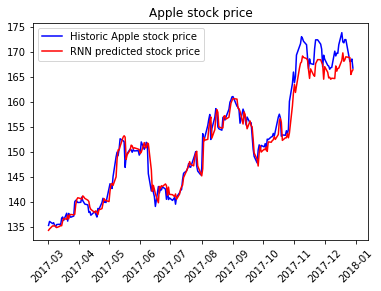

In [65]:
plt.plot(test[40:]['aapl'], color = 'blue', label = 'Historic Apple stock price')
plt.plot(test[40:]['aapl'].index, predicted_stock_price, color = 'red', label = 'RNN predicted stock price')
plt.xticks(rotation=45)
plt.title('Apple stock price')
plt.legend()
plt.show()

I would like to compare RNN model against a very simple model. For example using 10 and 3 previous daily stock prices and extrapolating this into the following day.

In [40]:
predicted_simple_1 = []
for i in range(40, len(test)):
    predicted_simple_1.append(test.iloc[i-1, 0] + (test.iloc[i-1, 0] - test.iloc[i-11, 0])/10)
predicted_simple_1 = np.array(predicted_simple_1)
    
predicted_simple_2 = []
for i in range(40, len(test)):
    predicted_simple_2.append(test.iloc[i-1, 0] + (test.iloc[i-1, 0] - test.iloc[i-4, 0])/3)
predicted_simple_2 = np.array(predicted_simple_2)

The below chart shows that simple model is actually better predicting stock prices than RNN which means there is some room for RNN tuning.

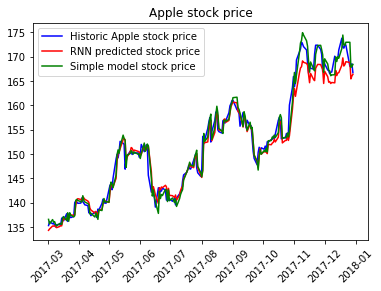

In [67]:
plt.plot(test[40:]['aapl'], color = 'blue', label = 'Historic Apple stock price')
plt.plot(test[40:]['aapl'].index, predicted_stock_price, color = 'red', label = 'RNN predicted stock price')
plt.plot(test[40:]['aapl'].index, predicted_simple_1, color = 'green', label = 'Simple model stock price')
plt.xticks(rotation=45)
plt.title('Apple stock price')
plt.legend()
plt.show()

Mean squared error of RNN model is higher than compared vs "simple" model

In [59]:
compare_dt = test[40:][['aapl']].copy()
compare_dt.rename(columns={compare_dt.columns[0]: 'Actual'}, inplace=True)
compare_dt['RNN'] = predicted_stock_price
compare_dt['Simple1'] = predicted_simple_1
compare_dt['Simple2'] = predicted_simple_2
compare_dt['RNN_error'] = ((compare_dt.RNN - compare_dt.Actual)/compare_dt.Actual)**2
compare_dt['S1_error'] = ((compare_dt.Simple1 - compare_dt.Actual)/compare_dt.Actual)**2
compare_dt['S2_error'] = ((compare_dt.Simple2 - compare_dt.Actual)/compare_dt.Actual)**2
compare_dt[['RNN_error', 'S1_error', 'S2_error']].mean()

RNN_error    0.000185
S1_error     0.000134
S2_error     0.000170
dtype: float64

MSE of RNN was in line or better than "simple" model for the most part of 2017 excluding last 2 months.

In [60]:
compare_dt.iloc[:160, 4:].mean()

RNN_error    0.000123
S1_error     0.000127
S2_error     0.000166
dtype: float64

I think it's possible to beat "simple" model. There is definitely more tuning of RNN needed. Although training RNN without proper hardware takes very long time and sets some limits for model tuning. Good additional independent variables would be important as well.

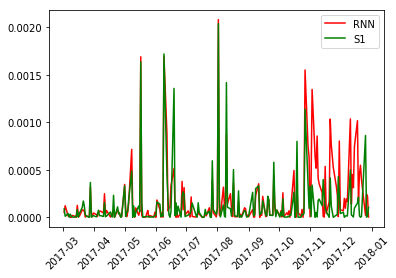

In [69]:
plt.plot(compare_dt['RNN_error'], color='red', label='RNN')
plt.plot(compare_dt['S1_error'], color='green', label='S1')
plt.legend()
plt.xticks(rotation=45)
plt.show()